<a href="https://colab.research.google.com/github/syedtoubur/Finding_oriC/blob/main/OriC_Prediction_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Taking The File

In [ ]:
#File uploading

with open('Vibrio_cholerae_genome.txt','r') as file:
  content=file.read()

In [ ]:
seq_list=content.replace('\n','')

In [ ]:
len(seq_list)

In [ ]:
seq_list=content

## 🔍 What is GC Skew?

GC Skew is a way of measuring the **imbalance between Guanine (G) and Cytosine (C)** nucleotides along a DNA sequence.


In simpler terms:
- If **G > C** at a position, the skew is **positive**.
- If **C > G**, the skew is **negative**.

---

## 📉 Why Does Minimum GC Skew Indicate oriC?

During replication:
- The **leading strand** is G-rich.
- The **lagging strand** is C-rich.

This results in a **shift in GC skew** across the genome. If we calculate GC skew **cumulatively**, the graph of this skew will often show:

- A **minimum (lowest point)** near the **origin of replication**.
- A **maximum** near the **terminus of replication**.


#Allocating GC SKEW minimum Position

In [ ]:

def minskewlist(text):
  skewlist=[]

  skew=0

  for i in range(len(text)):
    if text[i]=='G':
      skew=skew+1
    elif text[i]=='C':
      skew=skew-1

    skewlist.append(skew)
  minvalue=min(skewlist)
  minlist=[i+1 for i,j in enumerate(skewlist) if j==minvalue]

  return minlist

In [ ]:

def skewlist(text):
  skewlist_values=[]

  skew=0

  for i in range(len(text)):
    if text[i]=='G':
      skew=skew+1
    elif text[i]=='C':
      skew=skew-1

    skewlist_values.append(skew)

  return skewlist_values

In [ ]:
#Making the Skew Value List
skew_value_listC2=skewlist(seq_list)

In [ ]:
skew_value_listC2

In [ ]:
len(skew_value_listC2)

In [ ]:
#Taking the Minimum skew Value
minlist=minskewlist(seq_list)
minlist

#Finding using min list
Now, what we will do is set a range around the positions of the minimum GC skew values that we obtained. Then, we will take the midpoint of that range and define a broader region around it, which is likely to contain the oriC (origin of replication).

In [ ]:
ran=minlist[int(len(minlist)/2)]

In [ ]:
seq_portion=seq_list[ran-2000:ran+2000]

In [ ]:
len(seq_portion)

## 🔍 Characteristics of oriC Region

The **oriC** region (origin of replication) in bacterial genomes is a specialized DNA segment where replication begins. This region has several distinct and identifiable features that help in its recognition and function.

### 📌 Key Features:

- **DnaA Boxes:**  
  The oriC region contains **multiple DnaA boxes**, which are 9-mer consensus sequences (typically `TTATCCACA` in *E. coli*).  
  🔹 **At least 4–5 DnaA boxes** are usually required for effective binding of the DnaA protein to initiate replication.  
  🔹 These boxes can have **slight mismatches** (1–2 base differences) and still be functional.

- **Other Repeated K-mers:**  
  Apart from DnaA boxes, the oriC region often contains other **repetitive 9-mers** (or other k-mers) that appear frequently within a short range.  
  These are **not necessarily exact DnaA boxes** but tend to recur in the oriC region and may be involved in **structural DNA features or additional binding activities**.

- **Poly-AT Rich Regions:**  
  The oriC region is often flanked by or contains **AT-rich sequences**, which help in **strand separation** during the initiation of replication due to weaker hydrogen bonding.

By analyzing these features together — **DnaA box density, frequent repeating k-mers, and AT-rich segments** — one can more reliably predict the oriC region in a genome.



## 🧪 Finding Highly Repeated 9-mers in the oriC Region

In this step, we aim to detect the **functional signals** within the oriC region by identifying repeated DNA patterns (9-mers) that are characteristic of this region.

### 🎯 Objective:

We are going to search for **9-base-long DNA sequences (9-mers)** that:
- Appear **at least 6 times** within a window of **600 nucleotides**, and
- Are counted **even if they differ by 1 mismatch** (Hamming distance ≤ 1),
- Also include **reverse complements**, since many functional motifs can be palindromic or occur on the opposite strand.

### ✅ Why This Matters:

- These repeated 9-mers often include **DnaA boxes**, but also capture other **non-canonical or species-specific motifs** that recur frequently in oriC regions.
- Their **high density in a short region** strongly indicates functional importance, especially when aligned with other signals like **AT-rich areas** or **GATC clusters**.

### 🛠️ What We'll Do Next:

We will apply a custom search algorithm to:
1. Slide a window of 600 bp across our target sequence.
2. Count each 9-mer and its reverse complement, allowing for up to 1 mismatch.
3. Identify patterns that occur **6 or more times** in that window.
4. Use these frequent 9-mers to pinpoint a **clustered region** likely to contain the oriC.

This technique gives a **sequence-level signal** that complements the broader GC skew and AT-rich analyses we've already performed.


In [ ]:

def rev_complement(string):
  complements={'A':'T','T':'A','G':'C','C':'G'}
  rev_comp=''
  for i in string:
    rev_comp=complements[i]+rev_comp
  return rev_comp

In [ ]:
def hamming_distance(p1, p2):
    return sum(c1 != c2 for c1, c2 in zip(p1, p2))

def pattern_occurrence_with_mismatches(text, L, n, t, d):
    pattern_counts = {}       # Store counts of approximate patterns
    first_indices = {}        # First occurrence of each stored pattern
    result = {}               # Final patterns that satisfy the condition

    for i in range(len(text) - n + 1):
        current_pattern = text[i:i+n]
        rev=rev_complement(current_pattern)

        matched = False

        # Check all patterns we've seen so far
        for stored_pattern in pattern_counts:
            if (hamming_distance(current_pattern, stored_pattern) <= d) or (hamming_distance(rev,stored_pattern) <= d):
                # Check if current occurrence is far enough from first occurrence
                if i - first_indices[stored_pattern][0] >= L:
                    pattern_counts[stored_pattern] = 1
                    first_indices[stored_pattern] = [i]
                else:
                    pattern_counts[stored_pattern] += 1
                    first_indices[stored_pattern].append(i)
                    if pattern_counts[stored_pattern] == t:
                        result[stored_pattern] = first_indices[stored_pattern]
                matched = True
                break

        if not matched:
            # This pattern or anything similar hasn't been seen yet
            pattern_counts[current_pattern] = 1
            first_indices[current_pattern] = [i]

    return result




In [ ]:
finding_k_mer_positions=pattern_occurrence_with_mismatches(seq_portion,600,9,6,1)

In [ ]:
finding_k_mer_positions

**HERE WE DIDN'T FIND ANY K_MER THAT APPEARS 6 TIMES WITH REVERSE COMPLEMENT WHICH PROVES THAT THIS IS NOT THE TRUE ORIC**

## 🧭 Why GC Skew Minimum Alone May Not Work

Initially, we tried to identify the oriC region using the **minimum point of the GC skew** (often called the `minlist` approach). This is based on the idea that the **origin of replication** is usually located near the point where the number of G and C bases switches direction (GC skew minimum).

However, for some bacteria like **_Vibrio cholerae_**, this approach **did not accurately locate the oriC**.

### ❓ Why Didn't It Work?

- GC skew can be influenced by **genome rearrangements**, **horizontal gene transfers**, or **sequence inversions**.
- In some genomes, especially those with **multiple chromosomes or plasmids**, the skew minimum might be **shifted** or **not sharp enough**.
- Therefore, relying on the absolute GC skew minimum can lead to **incorrect predictions**.

---

**So now lets see the plot of GC skew and try to think what happened actually**

In [ ]:
import matplotlib.pyplot as plt
#histplot plotting index in x axis and skewlist[index] in y axis both for pattern and pattern1

shortcholera=skewlist(seq_list)

plt.plot(shortcholera,label='cholera')
plt.figure(figsize=(100, 10))
plt.legend()
plt.xlabel('index')
plt.ylabel('skewlist')
plt.show()

**Normally the GC skew plot is like this where the minimum indicates the oriC and maximum the terminus is the maximum**

 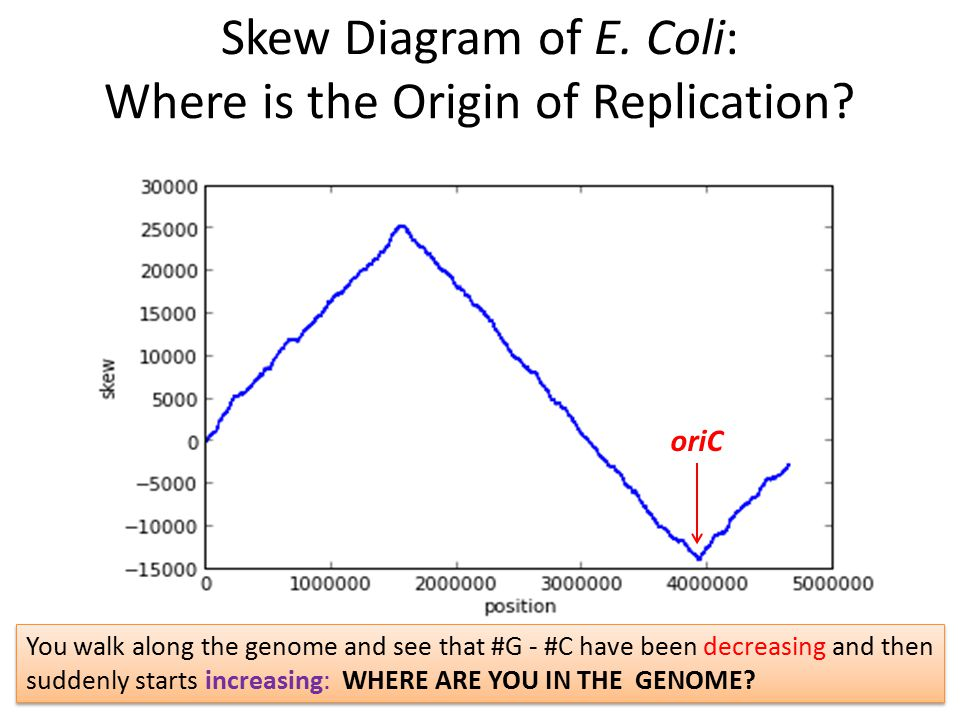

**But here it looks different but the same pattern has remained meaning before the ori there was decrease and after that increase in GC skew value so this is like local minima**

## 📉 Local Minima-Based Approach (Custom Idea)

Instead of focusing only on the absolute minimum, we examined the **shape of the GC skew graph**. We observed that in many cases, the oriC lies at a **local dip** — a region where the skew decreases and then begins to increase again.

So, we developed a custom function that:
- Slides across the GC skew values.
- Detects **local minima** by comparing a point to its surrounding region.
- Returns a list of such **local minimum candidates**.

> 🧠 **Note:** This method is a logical idea based on visual patterns and biological reasoning, but it is **not yet research-validated**. It can still provide useful leads when the global GC skew minimum is misleading.

This approach helped us better identify candidate oriC regions in *Vibrio cholerae* and potentially other complex genomes.

#Finding Ori New way

In [ ]:
def findingminima(skew_value_listC2,depth,gap):

  oridiction={}
  for i in range(depth,len(skew_value_listC2)-depth,gap):
    mean=(skew_value_listC2[i-int(depth/2)]+skew_value_listC2[i+int(depth/2)])/2
    mid=skew_value_listC2[i]
    diff=mid-mean
    oridiction[i]=diff
    minvalue=min(oridiction.values())
    lowerbound=minvalue-20
    upperbound=minvalue+20
    minlist=[k for k,v in oridiction.items() if ((lowerbound<=v) & (v<=upperbound))]
  return minlist




In [ ]:
listminima=findingminima(skew_value_listC2,100000,500)

In [ ]:
listminima

In [ ]:
predicted_ori_start=listminima[int(len(listminima)/2)]

In [ ]:
predicted_ori_start

In [ ]:
minima_seq_ran=seq_list[predicted_ori_start-2000:predicted_ori_start+2000]

In [ ]:
#If by giving exact hd=0 we get 3 then we are sure that it is the ori
finding_k_mer_positions=pattern_occurrence_with_mismatches(minima_seq_ran,600,9,6,0)


In [ ]:
finding_k_mer_positions #one thing is sure that the oriC is after 1000

**Now even with zero hamming distance meaning exact match we got two 9 mers that occured six times with their reverse complement**

This is Statistically quite impossible
And if you notice those 9 mers are only one base apart from each other this is a strong indication that among them one is the dnaA box

**And the proven dnaA box is ATGATCAAG**

Now we will try to make the position of OriC more exact by using AT rich regions

## 🧩 Final Step: Combining Poly-AT Clusters and k-mer Positions

After identifying all the frequent 9-mers (including reverse complements) that occur multiple times within the candidate oriC region, we now apply a **biological filter** using **poly-AT rich regions**.

### 🧬 Why Poly-AT Regions?

Poly-AT sequences are:
- Common near **DNA unwinding sites**.
- Known to appear on **both sides of the oriC** in circular bacterial chromosomes.
- Easier to unwind due to weaker hydrogen bonds, helping replication initiation.

---

## 🎯 What We Do in This Step

1. **Detect Poly-AT Clusters:**  
   We find windows (e.g., 30 bp) in the sequence that have a high AT content (≥ 90%). These are stored as cluster positions.

2. **Define the OriC Range:**
   - We **locate two nearby poly-AT clusters** (before and after a central region).
   - We define the oriC candidate region as the sequence **between those two clusters**.

3. **Filter k-mer Positions:**
   - From all the frequent k-mer positions found earlier, we select only those that **fall between the two poly-AT cluster boundaries**.
   - This improves specificity and ensures we stay within a biologically relevant region.

---

### ✅ Why This Works Well

This step leverages the **circular nature of bacterial chromosomes**, where replication often starts in a region flanked by poly-AT sequences. By combining:
- Frequent 9-mer patterns (like DnaA boxes or repeats),
- Biological markers (like poly-AT clusters),
we narrow down the **most likely oriC region** with better accuracy.

> ⚠️ Note: This method is heuristic but based on real biological signals and patterns observed across many bacterial genomes.


In [ ]:
finding_k_mer_one_hd=pattern_occurrence_with_mismatches(minima_seq_ran,600,9,6,1)

In [ ]:
finding_k_mer_one_hd

In [ ]:
all_positions = []
for positions in finding_k_mer_one_hd.values():
    all_positions.extend(positions)


In [ ]:
all_positions

#Combining the list with AT

combing the list we got with position of most frequent k mers with the list of poly AT region meaning as there is an immediate start of poly AT

In [ ]:
def find_poly_AT_regions(seq, window_size=50, AT_threshold=0.8):
    poly_AT_positions = []

    for i in range(len(seq) - window_size + 1):
        window = seq[i:i+window_size]
        at_count = sum(1 for base in window if base in ['A', 'T'])
        at_ratio = at_count / window_size

        if at_ratio >= AT_threshold:
            poly_AT_positions.append(i)

    return poly_AT_positions


In [ ]:
predicted_ori_start

In [ ]:
minima_seq=seq_list[predicted_ori_start-2000:predicted_ori_start+2000]

In [ ]:
AT_region=find_poly_AT_regions(minima_seq_ran,window_size=30,AT_threshold=0.8)
AT_region

In [ ]:
poly_at_window_size = 30

# Step 2: Identify poly-AT clusters (distance <= 10, adjustable)
def cluster_positions(positions, max_dist=10):
    clusters = []
    current_cluster = [positions[0]]

    for i in range(1, len(positions)):
        if positions[i] - positions[i-1] <= max_dist:
            current_cluster.append(positions[i])
        else:
            if len(current_cluster) >= 2:
                clusters.append(current_cluster)
            current_cluster = [positions[i]]

    if len(current_cluster) >= 2:
        clusters.append(current_cluster)

    return clusters




In [ ]:
# Step 3: Filter only clustered poly-AT starts and add window offset
clustered_poly_at = cluster_positions(sorted(AT_region))
clustered_poly_at_positions = [min(cluster)  for cluster in clustered_poly_at]



In [ ]:
clustered_poly_at

In [ ]:
clustered_poly_at_positions.sort()
clustered_poly_at_positions

In [ ]:
#Taking those who fell between two AT reg

def filter_between_clusters(ori_positions, poly_at_clusters):
    poly_at_clusters = sorted(poly_at_clusters)

    # Look for the first pair where a cluster surrounds ori positions
    for i in range(len(poly_at_clusters) - 1):
        start = poly_at_clusters[i]
        end = poly_at_clusters[i + 1]

        filtered = [pos for pos in ori_positions if start <= pos <= end]
        if len(filtered) >= 5:  # Adjustable threshold
            return filtered, start, end

    return [], None, None  # If no valid interval found

In [ ]:
filtered_hits, at_start, at_end = filter_between_clusters(all_positions, clustered_poly_at_positions)

In [ ]:
filtered_hits.sort()

In [ ]:
#We are taking region without poly AT regions
ori_with_out_AT=minima_seq_ran[filtered_hits[0]:filtered_hits[-1]+9] #Here Nine is okay containing all frequent 9 mers
ori_with_out_AT

In [ ]:
len(ori_with_out_AT)

In [ ]:
#Here is the real ori as the ori also contains poly AT regions
ori_with_at=minima_seq_ran[at_start:at_end+30]
ori_with_at

In [ ]:
len(ori_with_at)

## 🧪 Optional Enhancement: Detecting GATC Clusters for SeqA Binding

As a final (optional) enhancement, we analyze the **presence of GATC motifs** within the predicted oriC region. These motifs are biologically crucial for regulating **DNA replication timing**.

---

### 🧬 Why GATC is Important?

- The **GATC sequence** is a **target of DNA adenine methylation (Dam methylase)**.
- During replication, newly synthesized DNA strands are initially **unmethylated**, making the GATC sites temporarily **hemimethylated**.
- The protein **SeqA binds to these hemimethylated GATC sites**, delaying re-initiation of replication by preventing immediate rebinding of DnaA to the oriC region.

---

### 📏 How to Detect GATC Clusters?

We slide a small window (e.g., **100 bp**) across the predicted oriC region and count the number of GATC motifs. A **GATC cluster** is defined as:
- At least **3 or more GATC motifs** within a **100 bp window**.

---

### ✅ Why This Matters?

- **GATC motifs are scattered throughout the genome**, but clusters near oriC are **densely packed** to support SeqA regulation.
- This pattern helps **discriminate the true oriC** from other GATC-rich but functionally unrelated regions.

---

> ⚠️ Note: While GATC analysis is optional, it provides an additional **regulatory signal** that strengthens the confidence of oriC prediction.


In [ ]:
def k_mer_cluster_optimized(text, k_mer, L, min_count=3):
    """
    Find clusters of a given k-mer where at least min_count of them
    occur within a distance L.

    Parameters:
    - text: DNA sequence
    - k_mer: pattern to search (e.g., "GATC")
    - L: max allowed distance between first and last match in cluster
    - min_count: minimum number of matches needed to form a valid cluster

    Returns:
    - List of lists of positions, each representing a cluster
    """
    n = len(k_mer)
    positions = [i for i in range(len(text) - n + 1) if text[i:i+n] == k_mer]
    clusters = []


    for i in range(len(positions)):
        cluster = [positions[i]]
        for j in range(i+1, len(positions)):
            if positions[j] - positions[i] <= L:
                cluster.append(positions[j])
            else:
                break
        if len(cluster) >= min_count:
            clusters.append(cluster)

    return clusters


In [ ]:
gatc_cluster=k_mer_cluster_optimized(ori_with_at,'GATC',100)
gatc_cluster

**So we can see there are various clusters of GATC are forming here which further confirms that this is the ori region**